# Test validity step 3 : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$ becoming $P(r | ...) \propto s_c^t C(r)^{-1} s_c + ln|C(r)|$

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


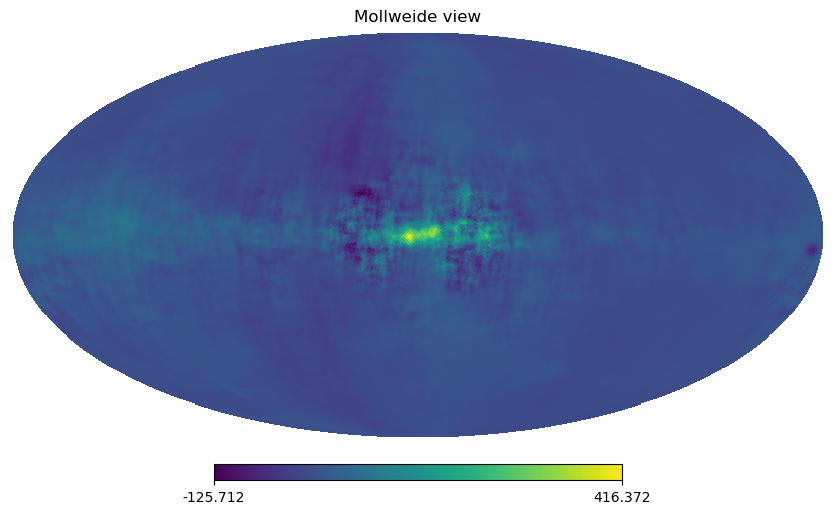

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v2/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'


In [6]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [7]:
reduction_noise = 10

In [8]:
freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)

In [9]:
instrument = get_instrument(instr_name)

instrument['depth_p'] /= reduction_noise
# get input freq maps
np.random.seed(noise_seed)
# freq_maps = get_observation(instrument, model, nside=NSIDE, noise=noise)[:, 1:, :]   # keep only Q and U
freq_maps_fgs = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=noise)[:, 1:, :]   # keep only Q and U


In [10]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

In [11]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.number_components, pos_special_freqs=[0,-1])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.number_components, init_params, pos_special_freqs=[0,-1])

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [12]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

# true_cmb_specra = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)
# true_cmb_specra_extended = np.zeros((6,MICMAC_sampler_obj.lmax+1))
# true_cmb_specra_extended[indices_polar,MICMAC_sampler_obj.lmin:] = true_cmb_specra

# input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=MICMAC_sampler_obj.nside, new=True, lmax=MICMAC_sampler_obj.lmax)[1:,...]

# input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), MICMAC_sampler_obj.number_frequencies).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix),order='F')
        
# input_cmb_maps = 

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [13]:
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps, jax_use=False)[0, :, :]

In [14]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

In [15]:
PRNGKey = random.PRNGKey(0)
wiener_filter_term = MICMAC_sampler_obj.solve_generalized_wiener_filter_term(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))

map_random_realization_xi = jnp.empty(0)
map_random_realization_chi = jnp.empty(0)
fluctuation_maps = MICMAC_sampler_obj.get_fluctuating_term_maps(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))

s_c_sample = wiener_filter_term + fluctuation_maps

CG-Python-0 WF finished in  None iterations !!
Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!


In [16]:
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter

In [17]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


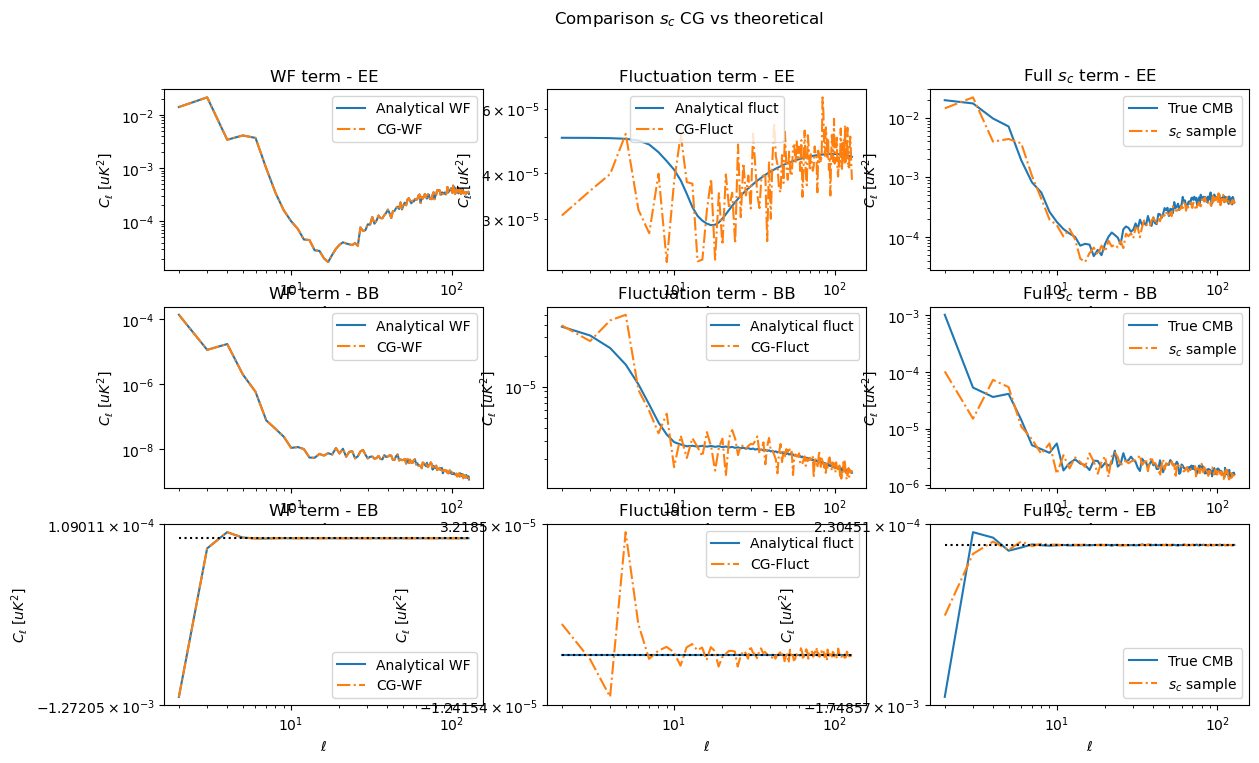

In [18]:
list_correl = ['EE', 'BB', 'EB']

map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=lmax, iter=n_iter)[indices_polar, lmin:]

covariance_noise = np.zeros_like(c_ell_true_CMB)

analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.eye(nstokes)/BtinvNB[0,0])
# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)

analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

s_c_WF_maps_extended = np.vstack([np.zeros_like(wiener_filter_term[0,...]), wiener_filter_term])
c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_maps_extended = np.vstack([np.zeros_like(fluctuation_maps[0,...]), fluctuation_maps])
c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_recovered_ext = np.vstack([np.zeros_like(s_c_sample[0]),s_c_sample])
c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(number_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')

    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')

    if j <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    
    plt.xlabel(r"$\ell$")
    plt.legend()


plt.show()

In [19]:
number_steps_sampler = 5000
# number_steps_sampler = 100
initial_step_size_r = 10**(-3)
initial_guess_r = 1e-2
initial_guess_r = 1e-4
# initial_guess_r = MICMAC_sampler_obj.r_true*0.99999

num_sample_AM = 50
epsilon_cov = 10**(-20)
scale_param = 2.4**2

In [20]:
c_ells_Wishart = jnp.zeros((3,lmax+1))
# c_ells_Wishart = micmac.get_cell_from_map_jax(s_c_sample, lmax=MICMAC_sampler_obj.lmax, n_iter=MICMAC_sampler_obj.n_iter)
c_ells_Wishart = c_ells_Wishart.at[:,lmin:].set(micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor))

In [21]:
true_cmb = np.zeros((6,lmax+1))
true_cmb[indices_polar,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor)
map_s_c = hp.synfast(true_cmb, nside, lmax=lmax, new=True)[1:]

In [22]:
c_ells_Wishart_modified = jnp.copy(c_ells_Wishart)
# for i in range(self.nstokes):
for i in range(c_ells_Wishart.shape[0]):
        c_ells_Wishart_modified = c_ells_Wishart_modified.at[i].set(c_ells_Wishart_modified[i] * (2*jnp.arange(MICMAC_sampler_obj.lmax+1) + 1))
red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell_jax(c_ells_Wishart_modified)[MICMAC_sampler_obj.lmin:]


In [23]:
all_r_sample = jnp.zeros(number_steps_sampler+1)
all_r_sample = all_r_sample.at[0].set(initial_guess_r)

all_r_sample_slow = jnp.zeros(number_steps_sampler+1)
all_r_sample_slow = all_r_sample_slow.at[0].set(initial_guess_r)

for i in range(0,number_steps_sampler+1):
    if i < num_sample_AM:
        step_size_r = initial_step_size_r
    else:
        step_size_r = jnp.sqrt(scale_param*(jnp.var(all_r_sample[:i]) + epsilon_cov))
    if i%100 == 0:
        print(i, step_size_r)
    # all_r_sample[i+1] = micmac.single_Metropolis_Hasting_step(random_PRNGKey=PRNGKey+3, old_sample=all_r_sample[i], 
    #                                     step_size=step_size_r, log_proba=MICMAC_sampler_obj.get_conditional_proba_C_from_r, 
    #                                     red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total)
    all_r_sample = all_r_sample.at[i+1].set(micmac.single_Metropolis_Hasting_step(random_PRNGKey=PRNGKey+3+i, old_sample=all_r_sample[i], 
                                        step_size=step_size_r, log_proba=MICMAC_sampler_obj.get_conditional_proba_C_from_r, 
                                        red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total))
    # all_r_sample_slow = all_r_sample_slow.at[i+1].set(micmac.single_Metropolis_Hasting_step(random_PRNGKey=PRNGKey+3+i, old_sample=all_r_sample[i], 
    #                                     step_size=step_size_r, log_proba=MICMAC_sampler_obj.get_slow_conditional_proba_C_from_r, 
    #                                     map_s_c=map_s_c, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total))
    


0 0.001
100 0.0058099495120730715
200 0.0043247590141018265
300 0.0036288707833482155
400 0.0031919871674973275
500 0.0028976045730859466
600 0.002665828025523307
700 0.00249511161464011
800 0.0023521015403865897
900 0.0022375145891104856
1000 0.0021446923763139415
1100 0.0020662798867408477
1200 0.0019935612941402348
1300 0.0019281326564215928
1400 0.0018806345109211031
1500 0.0018296525656627785
1600 0.0017814763515179863
1700 0.0017403343756992099
1800 0.0016979520568871022
1900 0.001666025654594141
2000 0.0016312490962552741
2100 0.001603938897156762
2200 0.0015783369553036466
2300 0.0015562502876847123
2400 0.0015317401462223228
2500 0.0015139247703266447
2600 0.0014958850081502732
2700 0.001470588679937092
2800 0.0014523240936489706
2900 0.0014400622037583617
3000 0.0014235607278454236
3100 0.0014087943285433988
3200 0.0013919557147022968
3300 0.0013809217565086294
3400 0.0013666273062407134
3500 0.0013542572547673801
3600 0.001347137859255919
3700 0.0013334215263193052
3800 0.00

In [24]:
log_space_r = np.logspace(-8,3, num=100)

if MICMAC_sampler_obj.r_true != 0:
        log_r_true = np.log10(MICMAC_sampler_obj.r_true)
        gap = .1
        log_space_r = np.logspace(log_r_true-gap,log_r_true+gap, num=100)
else:
        log_space_r = np.logspace(-20,-2, num=100)
c_ells_Wishart_modified = np.copy(c_ells_Wishart)
for i in range(nstokes):
        c_ells_Wishart_modified[i] *= 2*np.arange(lmax+1) + 1
red_c_ells_Wishart_modified = micmac.get_reduced_matrix_from_c_ell(c_ells_Wishart_modified)[lmin:]

all_logproba_r = np.array([MICMAC_sampler_obj.get_conditional_proba_C_from_r(r_logspace, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total) for r_logspace in log_space_r])

In [25]:
all_logproba_samples = np.array([MICMAC_sampler_obj.get_conditional_proba_C_from_r(r_sample, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total) for r_sample in all_r_sample])

In [26]:
# if MICMAC_sampler_obj.r_true != 0:
#         log_r_true = np.log10(MICMAC_sampler_obj.r_true)
#         gap = .7
#         log_space_r = np.logspace(log_r_true-gap,log_r_true+gap, num=100)
# else:
#         log_space_r = np.logspace(-20,-2, num=100)

# all_logproba_r_slow = np.array([MICMAC_sampler_obj.get_slow_conditional_proba_C_from_r(r_logspace, map_s_c=map_s_c, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total) for r_logspace in log_space_r])

In [27]:
r_fit = all_r_sample.mean()
print('R_fit :', r_fit)
r_max = log_space_r[np.where(all_logproba_r==all_logproba_r.max())[0][0]]
print('R_max :', r_max)

R_fit : 0.009974434579700047
R_max : 0.009976768591500403


In [28]:
# r_fit_slow = all_r_sample_slow.mean()
# print('R_fit :', r_fit)
# r_max_slow = log_space_r[np.where(all_logproba_r_slow==all_logproba_r_slow.max())[0][0]]
# print('R_max :', r_max)

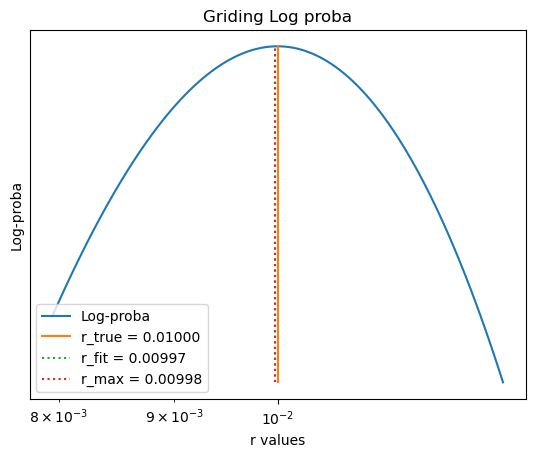

In [29]:
plt.plot(log_space_r, all_logproba_r, label='Log-proba')
plt.plot([MICMAC_sampler_obj.r_true, MICMAC_sampler_obj.r_true], [all_logproba_r.min(), all_logproba_r.max()], label='r_true = {:.5f}'.format(MICMAC_sampler_obj.r_true))
plt.plot([r_fit, r_fit], [all_logproba_r.min(), all_logproba_r.max()], ':', label='r_fit = {:.5f}'.format(r_fit))
plt.plot([r_max, r_max], [all_logproba_r.min(), all_logproba_r.max()], ':', label='r_max = {:.5f}'.format(r_max))
# plt.plot([1/r_true, 1/r_true], [all_logproba_r.min(), all_logproba_r.max()], label='1/r_true')
# plt.plot([10**(2), 10**(2)], [all_logproba_r.min(), all_logproba_r.max()], label='10^2')
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel('r values')
plt.ylabel('Log-proba')
plt.title('Griding Log proba')
# plt.ylim(ymax=all_logproba_r.max())
plt.legend()
plt.show()

In [30]:
# plt.plot(log_space_r, all_logproba_r_slow, label='Log-proba')
# plt.plot([MICMAC_sampler_obj.r_true, MICMAC_sampler_obj.r_true], [all_logproba_r_slow.min(), all_logproba_r_slow.max()], label='r_true = {:.5f}'.format(MICMAC_sampler_obj.r_true))
# plt.plot([r_fit_slow, r_fit_slow], [all_logproba_r_slow.min(), all_logproba_r_slow.max()], ':', label='r_fit = {:.5f}'.format(r_fit_slow))
# plt.plot([r_max_slow, r_max_slow], [all_logproba_r_slow.min(), all_logproba_r_slow.max()], ':', label='r_max = {:.5f}'.format(r_max_slow))
# # plt.plot([1/r_true, 1/r_true], [all_logproba_r.min(), all_logproba_r.max()], label='1/r_true')
# # plt.plot([10**(2), 10**(2)], [all_logproba_r.min(), all_logproba_r.max()], label='10^2')
# plt.xscale('log')
# plt.yscale('symlog')
# plt.xlabel('r values')
# plt.ylabel('Log-proba')
# plt.title('Griding Log proba slow')
# # plt.ylim(ymax=all_logproba_r.max())
# plt.legend()
# plt.show()

In [31]:
all_r_sample.shape

(5001,)

In [32]:
red_c_ells_samples = np.zeros((number_steps_sampler, lmax+1-lmin, nstokes, nstokes))

for i in range(number_steps_sampler):
    red_c_ells_samples[i,...] = theoretical_red_cov_r0_total + all_r_sample[i]*theoretical_red_cov_r1_tensor
    


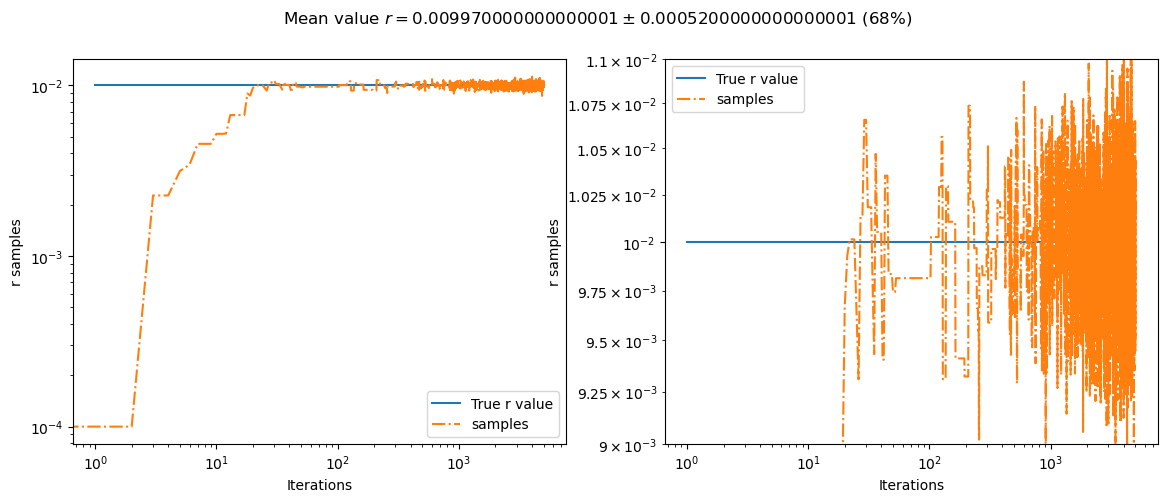

In [33]:
plt.figure(figsize=(14,5))
mean_r = np.round(all_r_sample.mean(), decimals=5)
std_r = np.round(all_r_sample.std(), decimals=5)
plt.suptitle(f"Mean value $r = {mean_r} \pm {std_r}$ (68%)")

plt.subplot(121)
plt.plot([1,number_steps_sampler], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], label='True r value')
plt.plot(np.arange(number_steps_sampler+1), all_r_sample, '-.', label='samples')
# plt.plot([1,number_steps_sampler], [r_max,r_max], '--', label='Max log-proba r value')
plt.xlabel('Iterations')
plt.ylabel('r samples')
plt.title('')
plt.loglog()
plt.legend()

plt.subplot(122)
plt.plot([1,number_steps_sampler], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], label='True r value')
plt.plot(np.arange(number_steps_sampler+1), all_r_sample, '-.', label='samples')
# plt.plot([1,number_steps_sampler], [r_max,r_max], '--', label='Max log-proba r value')
plt.xlabel('Iterations')
plt.ylabel('r samples')
plt.loglog()
plt.legend()
plt.ylim(ymin=MICMAC_sampler_obj.r_true*.9, ymax=MICMAC_sampler_obj.r_true*1.1)
plt.show()

plt.show()

In [34]:
log_proba_r_true = MICMAC_sampler_obj.get_conditional_proba_C_from_r(MICMAC_sampler_obj.r_true, red_sigma_ell=red_c_ells_Wishart_modified, theoretical_red_cov_r1_tensor=theoretical_red_cov_r1_tensor, theoretical_red_cov_r0_total=theoretical_red_cov_r0_total)

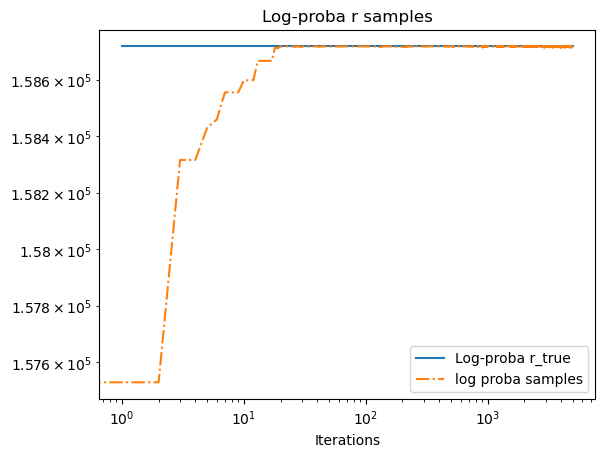

In [35]:
plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler+1), all_logproba_samples[:], '-.', label='log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Log-proba r samples')
plt.loglog()
plt.legend()
plt.show()

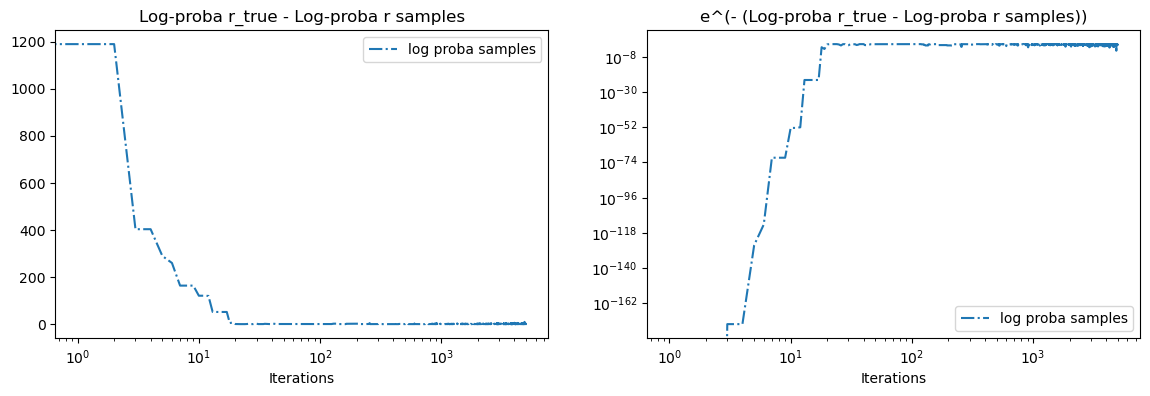

In [36]:
plt.figure(figsize=(14,4))
plt.subplot(121)
# plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler+1), -(all_logproba_samples[:]-log_proba_r_true), '-.', label='log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Log-proba r_true - Log-proba r samples')
# plt.loglog()
plt.xscale('log')
plt.legend()
plt.subplot(122)
# plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler+1), np.exp(all_logproba_samples[:]-log_proba_r_true), '-.', label='log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('e^(- (Log-proba r_true - Log-proba r samples))')
plt.loglog()
plt.legend()
plt.show()

/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_15400/2099821798.py:13: RuntimeWarning: overflow encountered in exp
  plt.plot(np.arange(number_steps_sampler)+1, np.exp(all_logproba_samples[1:]-all_logproba_samples[:-1]), '-.', label='$\delta$log proba samples')


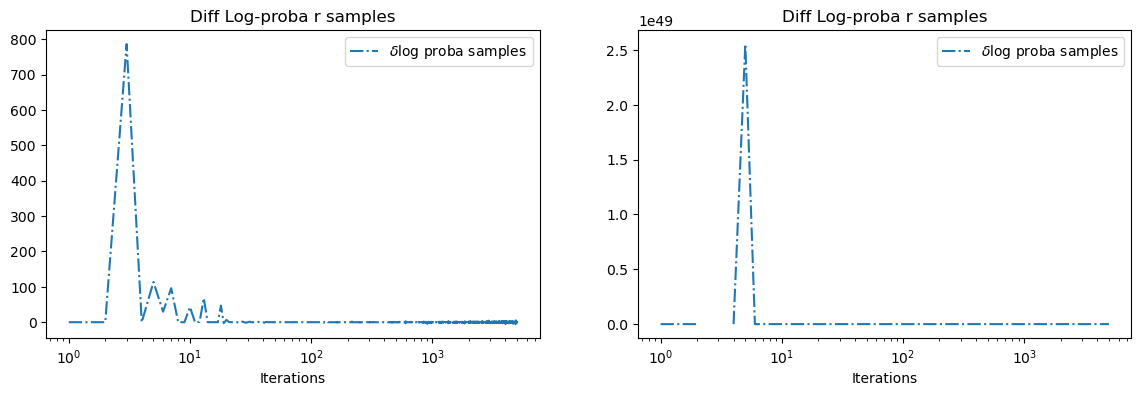

In [37]:
plt.figure(figsize=(14,4))
plt.subplot(121)
# plt.plot([1,number_steps_sampler], [log_proba_r_true,log_proba_r_true], label='Log-proba r_true')
plt.plot(np.arange(number_steps_sampler)+1, all_logproba_samples[1:]-all_logproba_samples[:-1], '-.', label='$\delta$log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Diff Log-proba r samples')
# plt.loglog()
plt.xscale('log')
plt.legend()

plt.subplot(122)
plt.plot(np.arange(number_steps_sampler)+1, np.exp(all_logproba_samples[1:]-all_logproba_samples[:-1]), '-.', label='$\delta$log proba samples')
# plt.plot([1,number_steps_sampler], [all_logproba_r.max(),all_logproba_r.max()], '--', label='Max log-proba')
plt.xlabel('Iterations')
plt.title('Diff Log-proba r samples')
# plt.loglog()
plt.xscale('log')
plt.legend()
plt.show()